<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Init-data" data-toc-modified-id="Init-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Init data</a></span><ul class="toc-item"><li><span><a href="#Estaciones" data-toc-modified-id="Estaciones-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Estaciones</a></span></li><li><span><a href="#Data-Mediciones" data-toc-modified-id="Data-Mediciones-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data Mediciones</a></span></li><li><span><a href="#Ozono" data-toc-modified-id="Ozono-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Ozono</a></span></li><li><span><a href="#Manzanas-Zonas-Metropolitanas" data-toc-modified-id="Manzanas-Zonas-Metropolitanas-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Manzanas Zonas Metropolitanas</a></span></li></ul></li><li><span><a href="#Denue-estados" data-toc-modified-id="Denue-estados-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Denue estados</a></span></li></ul></div>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from zopilote.misc import read_denue_18

from tqdm import tqdm_notebook
import requests
import json

pd.options.mode.chained_assignment = None

from axo_src.utils import calcular_areas_influencia, agg_info_por_area, wgs84_to_web_mercator, get_local_from_s3

%matplotlib inline

# Init data

## Estaciones

In [3]:
estaciones = pd.read_csv('/data/calidad_aire_presidencia/data_estaciones_sinaica_cvegeo.csv')
mask = (estaciones.lat.between(14, 34.5)) & (estaciones.long.between(-120, -70))
estaciones = estaciones[mask].rename(columns={'id':'estacionesid'})

print(estaciones.shape)
estaciones.head()

(180, 10)


,estacionesid,cvegeo,radius,_id,lat,long,nombre,codigo,redesid,date-insert
0,58,1000500013698027,0.001,5b8850e3e2705c1932e8300b,24.034472,-104.645028,ITD,ITD,42,2018-08-30 20:17:39.219
1,59,1000500014573001,0.001,5b8850e3e2705c1932e8300c,24.051556,-104.611361,IPN,IPN,42,2018-08-30 20:17:39.219
2,60,1000500015266011,0.001,5b8850e3e2705c1932e8300d,24.026778,-104.692975,SRNyMA,SRN,42,2018-08-30 20:17:39.219
3,65,1000700010166050,0.001,5b8850e3e2705c1932e8300e,25.551222,-103.502528,Campestre,CAM,43,2018-08-30 20:17:39.219
4,68,1100700010226014,0.001,5b8850e3e2705c1932e83011,20.517500,-100.815556,Policía,POL,45,2018-08-30 20:17:39.219


## Data Mediciones

In [4]:
mediciones = pd.read_csv('/data/calidad_aire_presidencia/data_mediciones_todas_estaciones_2.csv')
print(mediciones.shape)
mediciones.head()

(3240000, 8)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig
0,Durango,58,2018-08-01,13,PM10,Durango,1,988.61
1,Durango,58,2018-08-01,14,PM10,Durango,1,988.61
2,Durango,58,2018-08-01,15,PM10,Durango,1,988.60
3,Durango,58,2018-08-01,16,PM10,Durango,1,988.63
4,Durango,58,2018-08-01,17,PM10,Durango,1,988.63


In [5]:
estaciones_ciudad = mediciones[['city', 'state', 'estacionesid']].drop_duplicates()
estaciones_ciudad = estaciones_ciudad.merge(estaciones[['estacionesid', 'lat', 'long', 'nombre']],
                                            on='estacionesid')
print(estaciones_ciudad.shape)
estaciones_ciudad.head()

(121, 6)


,city,state,estacionesid,lat,long,nombre
0,Durango,Durango,58,24.034472,-104.645028,ITD
1,Durango,Durango,59,24.051556,-104.611361,IPN
2,Durango,Durango,60,24.026778,-104.692975,SRNyMA
3,Gómez Palacio,Durango,65,25.551222,-103.502528,Campestre
4,Celaya,Guanajuato,68,20.517500,-100.815556,Policía


In [6]:
estaciones_ciudad.groupby('city').estacionesid.nunique().sort_values(ascending=False).head()

city
Valle de México    32
Monterrey          11
Guadalajara        10
Toluca              6
León                3
Name: estacionesid, dtype: int64

## Ozono

In [7]:
medicion_contaminante = mediciones[mediciones.parametro=='O3']

# De acuerdo al análisis anterior, es buena idea filtrar valores demasiado grandes. Vamos a usar
# como filtro el mínimo valor de ozono para establecer calidad del aire muy mala según SEMARNAT que es 0.6 ppm
medicion_contaminante = medicion_contaminante[medicion_contaminante.valororig.between(0, 0.7)]

medicion_contaminante = medicion_contaminante.groupby('estacionesid').agg({'valororig':['mean', 'count'],
                                                                           'validoorig':'mean'}).reset_index()
medicion_contaminante.columns = ['estacionesid', 'valororig', 'num_registros', 'validoorig']

medicion_contaminante = medicion_contaminante.merge(estaciones[['estacionesid', 'lat', 'long', 'nombre']],
                                                    on='estacionesid')
medicion_contaminante = medicion_contaminante.merge(mediciones[['estacionesid', 'city']].drop_duplicates(),
                                                    on='estacionesid')

print(medicion_contaminante.shape)
medicion_contaminante.head()

(107, 8)


,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city
0,33,0.290461,143,1,21.883781,-102.295825,Centro,Aguascalientes
1,38,0.039118,2,1,32.631317,-115.444631,UABC,Mexicali
2,39,0.017146,5858,1,32.639722,-115.506389,COBACH,Mexicali
3,41,0.010098,365,1,32.603639,-115.485944,CESPM,Mexicali
4,46,0.021328,9040,1,32.529461,-116.921281,Laboratorio,Tijuana


In [8]:
mask = (medicion_contaminante.num_registros>2400)
filtered_medicion = medicion_contaminante[mask]

print(filtered_medicion.shape)
filtered_medicion.head()

(96, 8)


,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city
2,39,0.017146,5858,1,32.639722,-115.506389,COBACH,Mexicali
4,46,0.021328,9040,1,32.529461,-116.921281,Laboratorio,Tijuana
5,53,0.031892,8795,1,28.632775,-106.038867,SUR,Chihuahua
6,54,0.038020,4970,1,28.652228,-106.085358,Centro,Chihuahua
7,56,0.011542,5583,1,25.522694,-103.395806,CONALEP,Torreón


## Manzanas Zonas Metropolitanas

In [9]:
guadalajara_mnz = gpd.read_file('/home/fickincool/Escritorio/shapes/mnz_zonas_metro_2016/zm_Guadalajara')
toluca_mnz = gpd.read_file('/home/fickincool/Escritorio/shapes/mnz_zonas_metro_2016/zm_Toluca')
monterrey_mnz = gpd.read_file('/home/fickincool/Escritorio/shapes/mnz_zonas_metro_2016/zm_Monterrey')
vallemex_mnz = gpd.read_file('/home/fickincool/Escritorio/shapes/mnz_zonas_metro_2016/zm_ValleMexico')

mnz_zonasMet = pd.concat([guadalajara_mnz, toluca_mnz, vallemex_mnz, monterrey_mnz])
print(mnz_zonasMet.shape)
mnz_zonasMet.head()

(306288, 6)


,cvegeo,cvemun,geometry,tipo,tipomza,zona_met
0,1410101881963800,14101,(POLYGON ((-103.2616548203058 20.6992963995447...,Caserío Disperso,NaN,Guadalajara
1,1412000560123800,14120,(POLYGON ((-103.4067395796593 20.8337961095740...,Caserío Disperso,NaN,Guadalajara
2,1410101422552800,14101,(POLYGON ((-103.2313047403976 20.5612279998585...,Caserío Disperso,NaN,Guadalajara
3,1412001530015800,14120,(POLYGON ((-103.5798034902669 20.9096736301016...,Caserío Disperso,NaN,Guadalajara
4,1409800030012800,14098,(POLYGON ((-103.4131147799056 20.5608117200612...,Caserío Disperso,NaN,Guadalajara


# Denue estados

In [10]:
_edos = mnz_zonasMet.cvemun.map(lambda x: x[0:2]).unique()
_edos

array(['14', '15', '13', '09', '19'], dtype=object)

In [11]:
files_denue = '/data/misc/denue/denue_cveedo_%02i/'

denue = []

for e in tqdm_notebook(_edos):
    filename = files_denue %int(e) + 'conjunto_de_datos/denue_inegi_%02i_.csv' %int(e)
    if e=='15':
        filename = '/data/misc/denue/denue_cveedo_15/denue_15_csv/conjunto_de_datos/denue_inegi_15_.csv'
        
    aux_denue = read_denue_18(filename)
    denue.append(aux_denue)
    
denue = pd.concat(denue)
print(denue.shape)
denue.head()

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


(1748361, 11)


,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,cod_postal,entidad,latitud,longitud,cvegeo
0,abarrotes sin nombre,NaN,115113,Beneficio de productos agrícolas,6 a 10 personas,CALLE,46760,JALISCO,20.684912,-103.853558,140950001010A020
1,acuicola el rosario,ACUÍCOLA EL ROSARIO,112512,"Piscicultura y otra acuicultura, excepto camar...",6 a 10 personas,AVENIDA,47900,JALISCO,20.294616,-102.698892,1404700010070027
2,"acuicola estipac, s.c. de rl","ACUÍCOLA ESTIPAC, S.C. DE R.L.",114119,"Pesca y captura de peces, crustáceos, moluscos...",11 a 30 personas,CALLE,45740,JALISCO,20.360556,-103.724151,1411400050041021
3,acuicola la garita,NaN,112512,"Piscicultura y otra acuicultura, excepto camar...",6 a 10 personas,CALLE,46900,JALISCO,20.524417,-104.780811,1405800010322001
4,acuicola san ignacio carbonera,NaN,112512,"Piscicultura y otra acuicultura, excepto camar...",6 a 10 personas,CARRETERA,NaN,JALISCO,20.509923,-103.610377,1408300090081002


In [12]:
denue['aux_codigo'] = denue.codigo_act.map(lambda x: x[0:2])

In [13]:
# Clave scian industrias manufactureras: 31-33
rangos_per_ocu = ['51 a 100 personas', '251 y más personas', '31 a 50 personas', '101 a 250 personas']
denue_industria = denue[(denue.aux_codigo.isin(['31', '32', '33'])) & (denue.per_ocu.isin(rangos_per_ocu))]

rangos_a_numero = {'51 a 100 personas':75, '251 y más personas':300,
                   '31 a 50 personas':40, '101 a 250 personas':175}

denue_industria['num_empleados'] = denue_industria.per_ocu.map(rangos_a_numero)

print(denue_industria.shape)
denue_industria.head()

(7272, 13)


,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,cod_postal,entidad,latitud,longitud,cvegeo,aux_codigo,num_empleados
2679,accion alimenticia sa de cv,ACCIÓN ALIMENTICIA SA DE CV,311812,Panificación tradicional,51 a 100 personas,NaN,44939,JALISCO,20.648632,-103.366342,1403900012554008,31,75
2683,"acojinados y hules, s.a. de c.v.","ACOJINADOS Y HULES, S.A. DE C.V.",316219,Fabricación de huaraches y calzado de otro tip...,51 a 100 personas,CALLE,44440,JALISCO,20.634486,-103.333179,1403900013730021,31,75
2702,agencia ciudad guzman 367,SABRITAS S DE RL DE CV,311910,Elaboración de botanas,251 y más personas,CALLE,49000,JALISCO,19.705615,-103.466168,1402300010064017,31,300
2703,agoservicios profesionales,NaN,311411,Congelación de frutas y verduras,31 a 50 personas,AVENIDA,45640,JALISCO,20.476225,-103.510332,1409700342505005,31,40
2704,agrana fruit mexico sa de cv,AGRANA FRUIT MEXICO SA DE CV,311422,Conservación de frutas y verduras por procesos...,31 a 50 personas,CALZADA,47910,JALISCO,20.294906,-102.544571,140180001012A041,31,40


In [14]:
denue_industria.per_ocu.value_counts()

31 a 50 personas      2132
51 a 100 personas     2064
101 a 250 personas    1628
251 y más personas    1448
Name: per_ocu, dtype: int64

In [19]:
from axo_src.utils import calcular_areas_influencia, agg_info_por_area, wgs84_to_web_mercator, get_local_from_s3

# Variable global que usaremos como identificador de las tiendas en la tabla0
ID_COLUMN = 'estacionesid'

# Variable global donde vamos a guardar los features generados
path_features_axo = '/data/axo-promoda/processed/features'
path_tabla0='/data/calidad_aire_presidencia/data_estaciones_sinaica_cvegeo.csv'

# Necesitamos lat, lon para calcular las areas de influencia alrededor de cada sucursal
tabla0 = pd.read_csv(path_tabla0, usecols = [ID_COLUMN, 'lat', 'long', 'cvegeo'])

def get_data_influencia(data, agg_params, tabla0=tabla0, radio=3):

    df_areas = calcular_areas_influencia(tabla0, ID_COLUMN, 'lat', 'long', radio, max_rad=5)
    agg_residente = agg_info_por_area(df_areas, data, 'cvegeo', ID_COLUMN, agg_params)

    feature = tabla0.merge(agg_residente, on=ID_COLUMN,
                           how='left').drop(['lat', 'long'], axis=1)

    # Vamos a renombrar las columnas en area de influencia con formato 'nombre_radio' en metros
    parsed_radio = int(radio*1000)
    parsed_radio = str(parsed_radio)+'m'
    current_names = agg_residente.drop(ID_COLUMN, axis=1).columns.tolist()
    agg_names = [x+'_%s' %parsed_radio for x in current_names]

    # Cambiamos nombre de columnas
    names_dict = dict(zip(current_names, agg_names))
    feature.rename(columns=names_dict, inplace=True)

    return feature

In [27]:
tabla0_aux = tabla0[tabla0.estacionesid.isin(filtered_medicion.estacionesid)]


agregados_estacion = filtered_medicion.copy()

for radio in [1, 3, 5]:
    
    data_areaInfluencia = get_data_influencia(denue_industria,
                                              {'num_empleados':'sum', 'nom_estab':'count'},
                                              tabla0_aux, radio)
    
    agregados_estacion = agregados_estacion.merge(data_areaInfluencia.drop('cvegeo', axis=1), on='estacionesid')
    
print(agregados_estacion.shape)
agregados_estacion.head()

/home/fickincool/Escritorio/axo-promoda/axo_src/utils.py:59: UserWarning: El join entre áreas e información tiene NaNs. Cuidado con la agregación
  warnings.warn(mensaje)


(96, 14)


,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city,num_empleados_1000m,nom_estab_1000m,num_empleados_3000m,nom_estab_3000m,num_empleados_5000m,nom_estab_5000m
0,39,0.017146,5858,1,32.639722,-115.506389,COBACH,Mexicali,0.0,0.0,0.0,0,0.0,0
1,46,0.021328,9040,1,32.529461,-116.921281,Laboratorio,Tijuana,0.0,0.0,0.0,0,0.0,0
2,53,0.031892,8795,1,28.632775,-106.038867,SUR,Chihuahua,0.0,0.0,0.0,0,0.0,0
3,54,0.038020,4970,1,28.652228,-106.085358,Centro,Chihuahua,0.0,0.0,0.0,0,0.0,0
4,56,0.011542,5583,1,25.522694,-103.395806,CONALEP,Torreón,0.0,0.0,0.0,0,0.0,0


In [32]:
agregados_estacion[agregados_estacion.city=='Valle de México'].corr()

,estacionesid,valororig,num_registros,validoorig,lat,long,num_empleados_1000m,nom_estab_1000m,num_empleados_3000m,nom_estab_3000m,num_empleados_5000m,nom_estab_5000m
estacionesid,1.000000,0.377839,0.101680,NaN,-0.153182,-0.070569,0.049679,0.072224,-0.111460,-0.118131,-0.043595,-0.039111
valororig,0.377839,1.000000,-0.068798,NaN,-0.608461,-0.310379,-0.417945,-0.410933,-0.347722,-0.293300,-0.284135,-0.235323
num_registros,0.101680,-0.068798,1.000000,NaN,0.202693,-0.030065,0.247186,0.251407,0.156436,0.113296,0.206954,0.169879
validoorig,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,-0.153182,-0.608461,0.202693,NaN,1.000000,0.044379,0.365033,0.320235,0.297173,0.226752,0.176796,0.120777
long,-0.070569,-0.310379,-0.030065,NaN,0.044379,1.000000,-0.198937,-0.154195,-0.265791,-0.221655,-0.187242,-0.149056
num_empleados_1000m,0.049679,-0.417945,0.247186,NaN,0.365033,-0.198937,1.000000,0.976568,0.594568,0.472123,0.355634,0.268994
nom_estab_1000m,0.072224,-0.410933,0.251407,NaN,0.320235,-0.154195,0.976568,1.000000,0.579709,0.489134,0.383981,0.317669
num_empleados_3000m,-0.111460,-0.347722,0.156436,NaN,0.297173,-0.265791,0.594568,0.579709,1.000000,0.974161,0.895106,0.843232
nom_estab_3000m,-0.118131,-0.293300,0.113296,NaN,0.226752,-0.221655,0.472123,0.489134,0.974161,1.000000,0.927339,0.907091


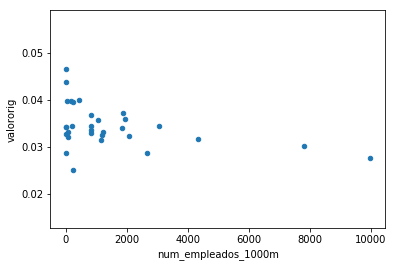

In [34]:
agregados_estacion[agregados_estacion.city=='Valle de México'].plot.scatter('num_empleados_1000m', 'valororig')

In [35]:
agregados_estacion[agregados_estacion.city=='Valle de México'].sort_values('num_empleados_1000m', ascending=False)

,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city,num_empleados_1000m,nom_estab_1000m,num_empleados_3000m,nom_estab_3000m,num_empleados_5000m,nom_estab_5000m
76,266,0.027575,6752,1,19.529167,-99.204722,Tlalnepantla,Valle de México,9975.0,58.0,31015.0,203,43480.0,302
81,271,0.030085,4766,1,19.526111,-99.082500,Xalostoc,Valle de México,7800.0,60.0,18450.0,152,24690.0,203
62,249,0.031693,4693,1,19.722222,-99.198611,Cuautitlán,Valle de México,4330.0,20.0,14500.0,77,17590.0,102
57,243,0.034355,5017,1,19.577222,-99.254167,Atizapán,Valle de México,3060.0,22.0,9100.0,73,12750.0,98
78,268,0.028767,4961,1,19.360833,-99.073889,UAM Iztapalapa,Valle de México,2660.0,22.0,11885.0,91,45475.0,383
77,267,0.032279,4171,1,19.602778,-99.177222,Tultitlán,Valle de México,2065.0,9.0,11155.0,67,20450.0,127
86,300,0.035883,5266,1,19.371667,-99.159167,Benito Juárez,Valle de México,1945.0,14.0,12640.0,107,34025.0,292
73,262,0.037142,4558,1,19.357500,-99.263056,Santa Fe,Valle de México,1890.0,10.0,6175.0,31,9225.0,53
65,252,0.034084,3900,1,19.384444,-99.117778,Iztacalco,Valle de México,1840.0,12.0,23120.0,221,55315.0,484
66,253,0.033076,7874,1,19.535000,-99.117778,La Presa,Valle de México,1215.0,12.0,4940.0,47,20945.0,180


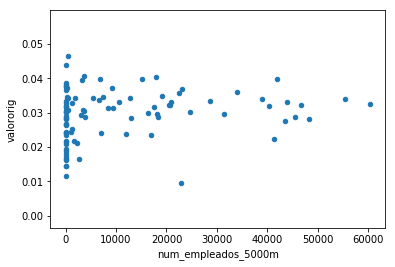

In [30]:
agregados_estacion.plot.scatter('num_empleados_5000m', 'valororig')